<a href="https://colab.research.google.com/github/Lizette95/Team_RM5_ClassificationPredict_Notebook/blob/olouw_eda/Team_RM5_ClassificationNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive') 

<a id="top"></a>
# Team RM5 Classification Predict Notebook
### Kaggle Submission: Team_RM5_SigmoidFreuds <sup>*</sup>
---
<img src="https://github.com/Lizette95/classification-predict-streamlit-template/blob/master/rm5_banner.png?raw=true" align="left">  

**Team Members:** Abednego Pakaree, Iman Mokwena, Lizette Loubser, Omphile Louw, Refiloe Elvis Phipa, Silindokuhle Kubheka    
**Supervisor:** Ridha Moosa

* [Notebook repo](https://github.com/Lizette95/Team_RM5_ClassificationPredict_Notebook)
* [Streamlit repo](https://github.com/Lizette95/classification-predict-streamlit-template)
* [Trello board](https://trello.com/b/pFKnwtGF/classificationteamrm5) 

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
 * Datasets and Variables
---
2. [Load Dependencies](#imports)
---
3. [Data Cleaning](#cleaning)
 * Load Data
 * Expand Contractions
 * Remove Noise
 * Remove Duplicate Rows
 * Remove Unwanted Columns
 * Tokenisation
 * Remove Stopwords
---
4. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Label
 * WordClouds
 * Word Counts
---
5. [Data Preprocessing](#preprocessing)
 * Lemmatisation
 * Feature Extraction
 * Split Training and Validation Sets
 * Resampling
---
6. [Modelling](#modelling)
 * Naive Bayes
 * Logistic Regression
 * K Nearest Neighbours
 * Linear SVM
 * Word2Vec with Logistic Regression
 * Doc2Vec with t-SNE
---
7. [Performance Evaluation](#evaluation)
 * Performance Metrics of Best Models
 * Hyperparameter Tuning of Best Models
---
8. [Model Analysis](#analysis)
 * Performance Metrics
 * ROC Curves and AUC
---
9. [Conclusion](#conclusion)
---
10. [Save Model and Output](#save)
---

<a id="intro"></a>
## 1. Introduction  

### Background

Machine learning is the study of computer algorithms that improve automatically through experience. It is a powerful branch of Artificial intelligence, dating as far back as 1952. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to do so.

Classification is a process of categorizing a given set of data into classes, It can be performed on both structured or unstructured data. The process starts with predicting the class of given data points. The classes are often referred to as target, label or categories.


### Problem Statement

Build a classification model that will predict the sentiments of Tweets related to climate change.


### Datasets and Variables

**Datasets:**  
* train.csv: We will use this data to train our model.  
* test.csv: We will use this data to test our model.  

**Variables:**  
* sentiment: Sentiment of tweet  
* message: Tweet body  
* tweetid: Unique Twitter ID  

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:  

| Class | Description                                                                              |
| :----:|:-----------------------------------------------------------------------------------------|
| **2** |**News:** The tweet links to factual news about climate change                            |
| **1** |**Pro:** The tweet supports the belief of man-made climate change                         |
| **0** |**Neutral:** The tweet neither supports nor refutes the belief of man-made climate change |
| **-1**|**Anti:** The tweet does not believe in man-made climate change                           |

<a id="imports"></a>
## 2. Load Dependencies

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
#import sys
#!{sys.executable} -m pip install wordcloud comet_ml scikit-learn

# Load Dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

from collections import Counter
from wordcloud import WordCloud
from gensim.models import Phrases
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="cleaning"></a>
## 3. Data Cleaning

### Load Data

In [3]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [4]:
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### Expand Contractions

In [6]:
contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are", "you've": "you have"}
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(text):
    """
    Expand contractions using dictionary of contractions.
    """
    text = text.lower()
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

train_data['message'] = train_data['message'].apply(expand_contractions)
test_data['message'] = test_data['message'].apply(expand_contractions)

### Remove Noise

In [7]:
http_regex = re.compile(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+')
url_regex = re.compile(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')
rt_regex = re.compile('^(RT|rt)( @\w*)?')
def remove_noise(tweet):
    """
    Remove noise from text data, such as newlines, punctuation, URLs and numbers.
    """
    new_tweet = tweet.replace('\n',' ') #Remove Newlines
    new_tweet = new_tweet.replace('"',' ') #Remove Text Delimeters
    new_tweet = new_tweet.replace('&amp',' ') #Remove Ampersands
    new_tweet = http_regex.sub('', new_tweet) #Remove http URLs
    new_tweet = url_regex.sub('', new_tweet) #Remove other URLs
    new_tweet = rt_regex.sub('', new_tweet) #Remove RTs
    new_tweet = re.sub(r'#(RT|rt)*', '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'@\w*', '', new_tweet) #Remove Mentions
    new_tweet = re.sub('\w*\d\w*','', new_tweet) #Remove Numbers/Words with Numbers
    new_tweet = re.sub('[^a-zA-z\s]', '', new_tweet) #Remove Punctuation
    new_tweet = new_tweet.strip() #Remove Excess Whitespace
    return new_tweet

train_data['message'] = train_data['message'].apply(remove_noise)
test_data['message'] = test_data['message'].apply(remove_noise)

### Remove Duplicate Rows
We can test our models with and without duplicate rows (retweets) to determine if they have an effect on the model's performance. A retweet might be considered as an individual sentiment (wording??).

In [8]:
print('There are ' + str(train_data['message'].duplicated().sum()) + ' duplicate rows in the training set.')
print('There are ' + str(test_data['message'].duplicated().sum()) + ' duplicate rows in the testing set.')

There are 2499 duplicate rows in the training set.
There are 1481 duplicate rows in the testing set.


In [9]:
# Drop duplicate rows/retweets
# train_data = train_data.drop_duplicates(subset='message', keep='first')
# test_data = test_data.drop_duplicates(subset='message', keep='first')

### Remove Unwanted Columns

In [10]:
train_data = train_data.drop('tweetid', axis=1)
train_data['sentiment'] = train_data.pop('sentiment')
train_data.head()

,message,sentiment
0,polyscimajor epa chief does not think carbon d...,1
1,it is not like we lack evidence of anthropogen...,1
2,researchers say we have three years to act on ...,2
3,todayinmaker wired was a pivotal year in the...,1
4,it is and a racist sexist climate change deny...,1


In [11]:
tweetid = test_data['tweetid'] #Save for Output File
test_data = test_data.drop('tweetid', axis=1)
test_data.head()

,message
0,europe will now be looking to china to make su...
1,combine this with the polling of staffers re c...
2,the scary unimpeachable evidence that climate ...
3,putin got to you too jill trump does not bel...
4,female orgasms cause global warming sarcastic ...


### Tokenisation

In [12]:
train_data['message'] = train_data['message'].apply(word_tokenize)
test_data['message'] = test_data['message'].apply(word_tokenize)

In [13]:
train_data.head()

,message,sentiment
0,"[polyscimajor, epa, chief, does, not, think, c...",1
1,"[it, is, not, like, we, lack, evidence, of, an...",1
2,"[researchers, say, we, have, three, years, to,...",2
3,"[todayinmaker, wired, was, a, pivotal, year, i...",1
4,"[it, is, and, a, racist, sexist, climate, chan...",1


In [14]:
test_data.head()

,message
0,"[europe, will, now, be, looking, to, china, to..."
1,"[combine, this, with, the, polling, of, staffe..."
2,"[the, scary, unimpeachable, evidence, that, cl..."
3,"[putin, got, to, you, too, jill, trump, does, ..."
4,"[female, orgasms, cause, global, warming, sarc..."


### Remove Stopwords

In [16]:
nltk.download('stopwords')
def remove_stopwords(text):
    """
    Remove stopwords from text data.
    """
    stop_words = stopwords.words('english')
    stop_words.extend(['https','via'])
    stop_words = set(stop_words)
    return [word for word in text if not word in stop_words]
    
train_data['message'] = train_data['message'].apply(remove_stopwords)
test_data['message'] = test_data['message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
train_data.head()

,message,sentiment
0,"[polyscimajor, epa, chief, think, carbon, diox...",1
1,"[like, lack, evidence, anthropogenic, global, ...",1
2,"[researchers, say, three, years, act, climate,...",2
3,"[todayinmaker, wired, pivotal, year, war, clim...",1
4,"[racist, sexist, climate, change, denying, big...",1


In [18]:
test_data.head()

,message
0,"[europe, looking, china, make, sure, alone, fi..."
1,"[combine, polling, staffers, climate, change, ..."
2,"[scary, unimpeachable, evidence, climate, chan..."
3,"[putin, got, jill, trump, believe, climate, ch..."
4,"[female, orgasms, cause, global, warming, sarc..."


<a id="EDA"></a>
## 4. Exploratory Data Analysis

<font color='green'>
________________________________________________________________________________________________________________________________________________________________
</font>

## Additions
Check tweet text of original tweet. `Check also after cleaning`

Because there is nothing positive about global warming, I am assuming that pro-global warming tweets should express some sort of negativity or synicism.

<font color='red'> Assumption is wrong </font>:
The distributions appear to be very similar. Don't know how much of it is due to number of positive vs number negative sentiments.

Neutral and News tend be more nuetral than the other classes. Nuetral also tends to be more positive than the rest. 


In [19]:
# want to check dirty data first
df_train = pd.read_csv('Data/train.csv')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


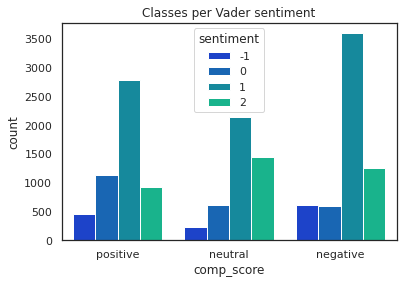

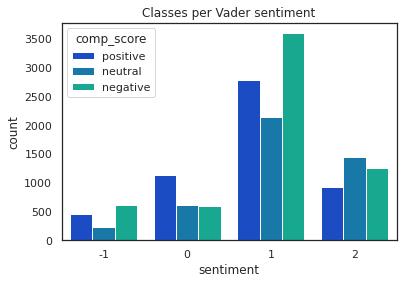

Positive
 1    2794
 0    1141
 2     924
-1     464
Name: sentiment, dtype: int64
Neutral
 1    2136
 2    1454
 0     622
-1     226
Name: sentiment, dtype: int64
Negative
 1    3600
 2    1262
-1     606
 0     590
Name: sentiment, dtype: int64


In [20]:
# @title Vader sentiment
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
 
df = df_train.copy()

#instantiate Sentiment analyzer
sid = SentimentIntensityAnalyzer()

# create function to determine if sentiment is positive, nuetral or negative
def sent_decider(compound):
  neutral_point = 0.1
  if compound >= neutral_point:
    return 'positive'#1
  elif compound <= -neutral_point:
    return 'negative' #-1
  else: 
    return 'neutral'#0

#Get sentiment
df['scores'] = df['message'].apply(lambda review: sid.polarity_scores(review))

df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df['comp_score'] = df['compound'].apply(sent_decider)#lambda c: 'pos' if c >=0 else 'neg')

#plot sentiment
sns.countplot(x='comp_score',data=df,palette='winter', hue='sentiment')
plt.title('Classes per Vader sentiment')
plt.show()

sns.countplot(x='sentiment',data=df,palette='winter', hue='comp_score')
plt.title('Classes per Vader sentiment')
plt.show()


print('Positive')
print(df[df['comp_score']=='positive'].sentiment.value_counts())
print('Neutral')
print(df[df['comp_score']=='neutral'].sentiment.value_counts())
print('Negative')
print(df[df['comp_score']=='negative'].sentiment.value_counts())

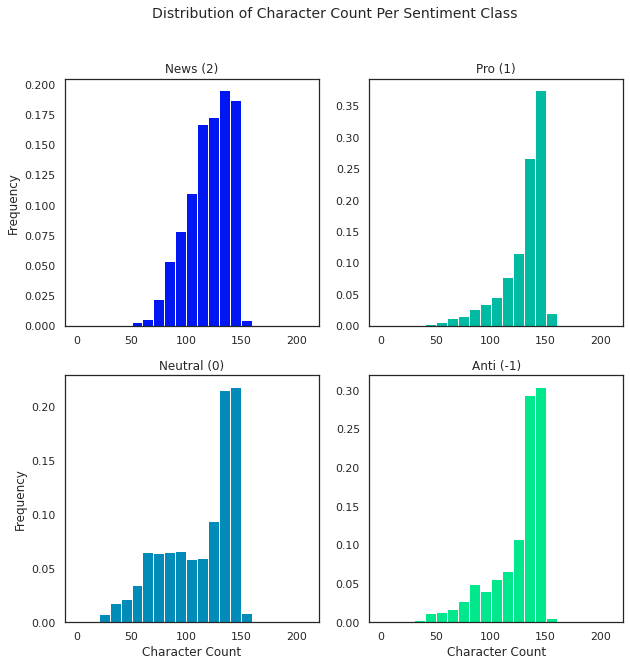

In [21]:
# @title Tweet Character lengths
df_train['number_of_characters'] = df_train['message'].apply(lambda x: len(x))
df_train.describe()

#plot
# Distribution of Character Count Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Distribution of Character Count Per Sentiment Class', fontsize=14)

bins = range(0, 211, 10)

train_news = df_train[df_train['sentiment']==2]
axis[0, 0].hist(train_news['number_of_characters'], 
                bins=bins, 
                weights=np.zeros(len(train_news)) + 1. / len(train_news),
                color='#0017F3')
axis[0, 0].set_title('News (2)')
axis[0, 0].set_ylabel('Frequency')

train_neutral = df_train[df_train['sentiment']==0]
axis[1, 0].hist(train_neutral['number_of_characters'], 
                bins=bins, 
                weights=np.zeros(len(train_neutral)) + 1. / len(train_neutral),
                color='#008BB9')
axis[1, 0].set_title('Neutral (0)')
axis[1, 0].set_ylabel('Frequency')
axis[1, 0].set_xlabel('Character Count')

train_pro = df_train[df_train['sentiment']==1]
axis[0, 1].hist(train_pro['number_of_characters'], 
                bins=bins, 
                weights=np.zeros(len(train_pro)) + 1. / len(train_pro),
                color='#00BAA2')
axis[0, 1].set_title('Pro (1)')

train_anti = df_train[df_train['sentiment']==-1]
axis[1, 1].hist(train_anti['number_of_characters'], 
                weights=np.zeros(len(train_anti)) + 1. / len(train_anti),
                bins=bins, 
                color='#00E88B')
axis[1, 1].set_title('Anti (-1)')
axis[1, 1].set_xlabel('Character Count')

plt.show()

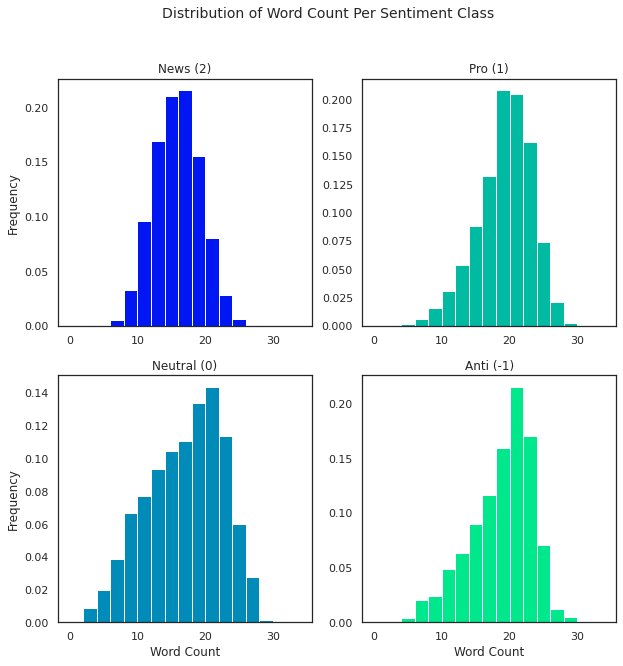

In [22]:
# @title Tweet word lenths
df_train['number_of_words'] = df_train['message'].apply(lambda x: len(x.split(' ')))
df_train.describe()

# Plot
# Distribution of Word Count Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Distribution of Word Count Per Sentiment Class', fontsize=14)

bins = range(0, 36, 2)

train_news = df_train[df_train['sentiment']==2]
axis[0, 0].hist(train_news['number_of_words'], 
                bins=bins, 
                weights=np.zeros(len(train_news)) + 1. / len(train_news),
                color='#0017F3')
axis[0, 0].set_title('News (2)')
axis[0, 0].set_ylabel('Frequency')

train_neutral = df_train[df_train['sentiment']==0]
axis[1, 0].hist(train_neutral['number_of_words'], 
                bins=bins, 
                weights=np.zeros(len(train_neutral)) + 1. / len(train_neutral),
                color='#008BB9')
axis[1, 0].set_title('Neutral (0)')
axis[1, 0].set_ylabel('Frequency')
axis[1, 0].set_xlabel('Word Count')

train_pro = df_train[df_train['sentiment']==1]
axis[0, 1].hist(train_pro['number_of_words'], 
                bins=bins, 
                weights=np.zeros(len(train_pro)) + 1. / len(train_pro),
                color='#00BAA2')
axis[0, 1].set_title('Pro (1)')

train_anti = df_train[df_train['sentiment']==-1]
axis[1, 1].hist(train_anti['number_of_words'], 
                weights=np.zeros(len(train_anti)) + 1. / len(train_anti),
                bins=bins, 
                color='#00E88B')
axis[1, 1].set_title('Anti (-1)')
axis[1, 1].set_xlabel('Word Count')

plt.show()

Check if URLs have anything to do with distribution of sentiments. 
It appears the distribution remains the same excluding when there is 1 or more  URLs (excluding news). News agancies appear to be in majority for 2 tweets (even though news tweets are less than half the number of pro-climate change tweets). Also news groups are more likely to have links than not.



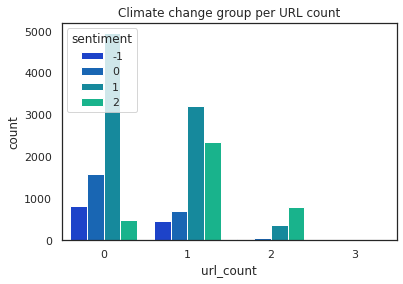

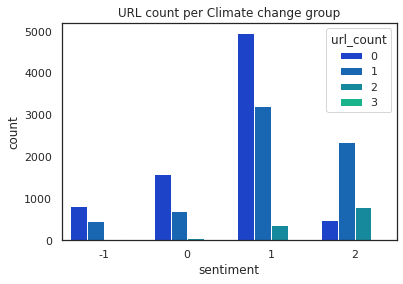

In [23]:
# @title Count URLs
import re

url_text = r"https?://t\.co/\S+"

df_train['url_list'] = df_train['message'].apply(
                                lambda tweet: re.findall(url_text, tweet))

df_train['url_count'] = df_train['url_list'].apply(len)

#Get sentiment

#plot sentiment
sns.countplot(x='url_count',data=df_train,palette='winter', hue='sentiment')
plt.title('Climate change group per URL count')
plt.show()

sns.countplot(x='sentiment',data=df_train,palette='winter', hue='url_count')
plt.title('URL count per Climate change group')
plt.show()

Manually building dictionary because sites like 'rawstory.com' block/throw error saying connection refused when using requests or urlparse packages.  Some googling says it's because of firewalls and some websites limiting number of requests from specific IP addresses in a specified period. These packages also have issues with sites the redirect.

In [ ]:
#@title url dictionary

import ast
with open('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/2 Classification/3 Predict/url_dict.txt', 'r') as f:
  url_dict = ast.literal_eval(f.read())
# url_dict

In [25]:
# @title Selenium setup on colab
%%capture
!pip install selenium
!apt-get update # ensures ubuntu machine running colab's apt is up to date
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver') #add path var
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') #run without UI
chrome_options.add_argument('--no-sandbox') 
chrome_options.add_argument('--disable-dev-shm-usage')

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (122 kB/s)
Reading package lists... Done
Reading package lists... Done
Building d

In [26]:
import timeit
rows= list(df_train.iterrows())
checks = [row[1]['url_list'] for row in rows]
not_found = []

#load url dictionary. link on drive: https://drive.google.com/file/d/1CufT4s8-2T-RArLyprPxd5zqdejt9bgo/view?usp=sharing
with open('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/2 Classification/3 Predict/url_dict.txt', 'r') as f:
  url_dict = ast.literal_eval(f.read())

t1 = timeit.default_timer()
for urls in checks[1050:1250]:
  for url in urls:
    if url:
      if url in url_dict.keys():
        continue
      else:
        try:
          wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
          wd.get(url)
          url_dict[url] = wd.current_url
        except:
          not_found.append(url)
t2 = timeit.default_timer()

print(t2-t1)

with open('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/2 Classification/3 Predict/url_dict.txt', 'w') as f:
  f.write(str(url_dict))


with open('/content/drive/My Drive/Colab Notebooks/EDSA/2 Machine Learning/2 Classification/3 Predict/url_not_found.txt', 'w') as f:
  f.write(str(not_found))

1335.495841897


In [27]:
len(url_dict)

918

In [28]:
# @title URL Convert URL in dataframe

def expand_short_url(short_url, url_dict=url_dict):
  if short_url in url_dict.keys():
    return url_dict[short_url]
  else:
    return None


df_train['expanded_urls'] = df_train['url_list'].apply(
          lambda url_list: [expand_short_url(url) for url in url_list if url]
          )


Check for links being shared. Extract domains and check which is most common


In [29]:
# @title Check Domains

# !pip install tldextract
import tldextract
# tldextract.extract(df_train['long_urls'][0][0]).domain

df_train['domains'] = df_train['expanded_urls'].apply(
    lambda urls: [tldextract.extract(url).domain for url in urls if url]
    )

# count domains
domain_count = {}
for ind, row in df_train.iterrows():
  for i, domain in enumerate(row['domains']):
    if domain:
      if domain in domain_count.keys():
        domain_count[domain] += 1
      else:
        domain_count[domain] = 1


In [30]:
df_train.head()

,sentiment,message,tweetid,number_of_characters,number_of_words,url_list,url_count,expanded_urls,domains
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140,19,[https://t.co/yeLvcEFXkC],1,[https://mashable.com/2017/03/09/pruitt-carbon...,[mashable]
1,1,It's not like we lack evidence of anthropogeni...,126103,62,10,[],0,[],[]
2,2,RT @RawStory: Researchers say we have three ye...,698562,140,19,"[https://t.co/WdT0KdUr2f, https://t.co/Z0ANPT…]",2,[https://www.rawstory.com/2017/06/researchers-...,"[rawstory, t]"
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99,15,[https://t.co/44wOTxTLcD],1,[https://www.wired.com/2016/12/2016-pivotal-ye...,[wired]
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122,18,[],0,[],[]


<font color='green'>
________________________________________________________________________________________________________________________________________________________________
</font>

## Original

### Data Summary

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   sentiment  15819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 247.3+ KB


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
dtypes: object(1)
memory usage: 82.5+ KB


---
From the above summaries, we note that:
* None of our datasets have **missing values**
* There is no **sentiment** column in the test data, as this is the **label** that we want to predict
* There are **15 818** entries in our training dataset
* There are **10 545** entries in our testing dataset

After removing retweets, we note that:
* There are **13 316** unique entries in our training dataset
* There are **9 062** unique entries in our testing dataset

### Label
We can examine the number of tweets that fall within a sentiment class and calculate the proportion of tweets that is represented by each class.

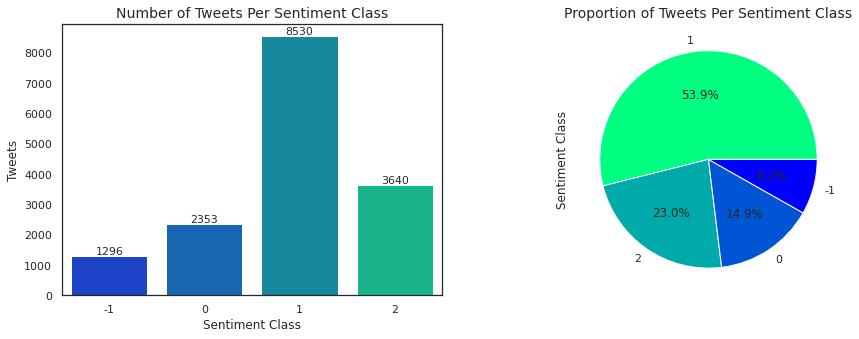

In [33]:
# Number of Tweets Per Sentiment Class
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='sentiment',data=train_data,palette='winter',ax=axis[0])
axis[0].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[0].set_xlabel('Sentiment Class')
axis[0].set_ylabel('Tweets')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')

train_data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[1])
axis[1].set_title('Proportion of Tweets Per Sentiment Class',fontsize=14)
axis[1].set_ylabel('Sentiment Class')
    
plt.show()

The graphs reveal that our data is imbalanced, as more than 50% of the entries fall within sentiment class "1". This will have to be addressed in the data preprocessing step before building our models.

In [34]:
# Calculate Word Count Per Sentiment Class
train_news = train_data[train_data['sentiment']==2]
train_news['words'] = train_news['message'].apply(lambda x: len(x))

train_pro = train_data[train_data['sentiment']==1]
train_pro['words'] = train_pro['message'].apply(lambda x: len(x))

train_neutral = train_data[train_data['sentiment']==0]
train_neutral['words'] = train_neutral['message'].apply(lambda x: len(x))

train_anti = train_data[train_data['sentiment']==-1]
train_anti['words'] = train_anti['message'].apply(lambda x: len(x))

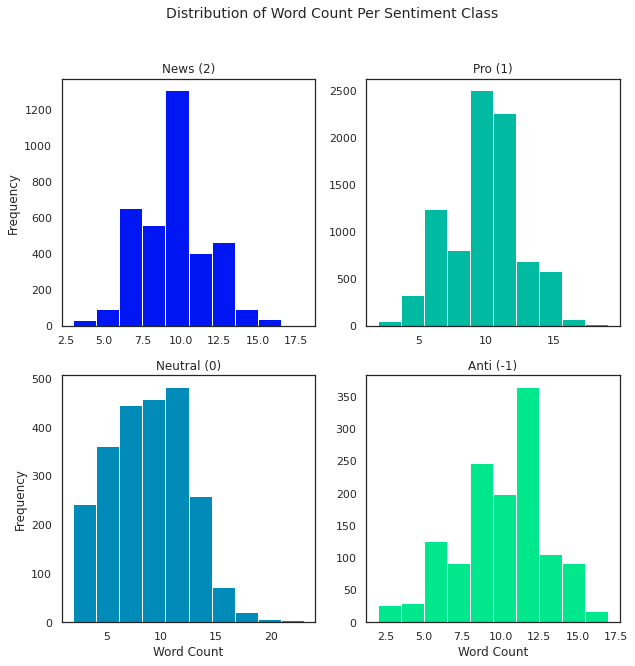

In [35]:
# Distribution of Word Count Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Distribution of Word Count Per Sentiment Class', fontsize=14)

axis[0, 0].hist(train_news['words'], bins=10, color='#0017F3')
axis[0, 0].set_title('News (2)')
axis[0, 0].set_ylabel('Frequency')

axis[1, 0].hist(train_neutral['words'], bins=10, color='#008BB9')
axis[1, 0].set_title('Neutral (0)')
axis[1, 0].set_ylabel('Frequency')
axis[1, 0].set_xlabel('Word Count')

axis[0, 1].hist(train_pro['words'], bins=10, color='#00BAA2')
axis[0, 1].set_title('Pro (1)')

axis[1, 1].hist(train_anti['words'], bins=10, color='#00E88B')
axis[1, 1].set_title('Anti (-1)')
axis[1, 1].set_xlabel('Word Count')

plt.show()

### WordClouds   
Wordclouds can be used to visualise text data, where the frequency of each word is proportional to the word size.

In [36]:
# Make Wordclouds
def wc(df):
    """
    Join words to create wordclouds.
    """
    words = ''
    for i in df:  
        words += " ".join(i)+" "
    return words
# Training Set
train_words = wc(train_data['message'])
train_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter', min_font_size=10).generate(train_words)
# Testing Set
test_words = wc(test_data['message'])
test_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter_r', min_font_size=10).generate(test_words)

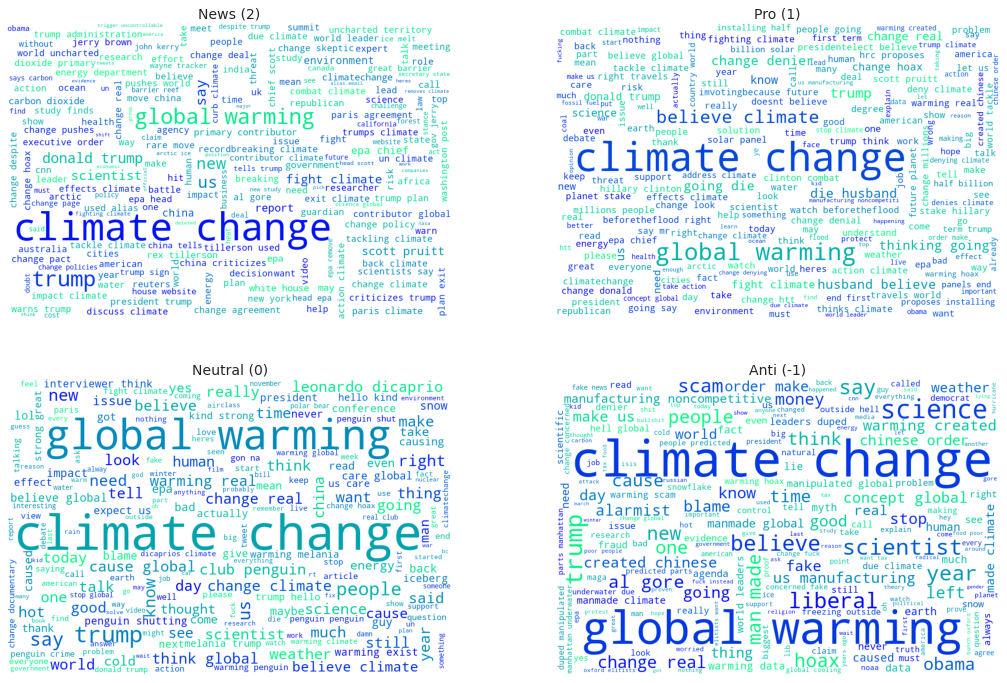

In [37]:
# Wordcloud Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

news = wc(train_news['message'])
news_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter').generate(news)
axis[0, 0].imshow(news_wordcloud)
axis[0, 0].set_title('News (2)',fontsize=14)
axis[0, 0].axis("off") 

neutral = wc(train_neutral['message'])
neutral_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(neutral)
axis[1, 0].imshow(neutral_wordcloud)
axis[1, 0].set_title('Neutral (0)',fontsize=14)
axis[1, 0].axis("off") 

pro = wc(train_pro['message'])
pro_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(pro)
axis[0, 1].imshow(pro_wordcloud)
axis[0, 1].set_title('Pro (1)',fontsize=14)
axis[0, 1].axis("off") 

anti = wc(train_anti['message'])
anti_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(anti)
axis[1, 1].imshow(anti_wordcloud)
axis[1, 1].set_title('Anti (-1)',fontsize=14)
axis[1, 1].axis("off") 

plt.show()

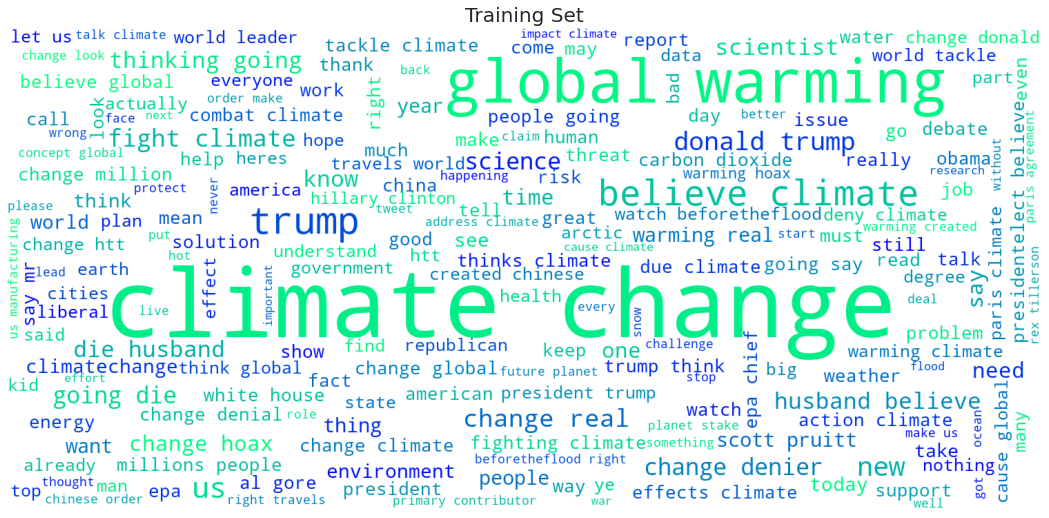

In [38]:
# Wordcloud for Training Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Training Set",fontsize=20)
plt.imshow(train_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

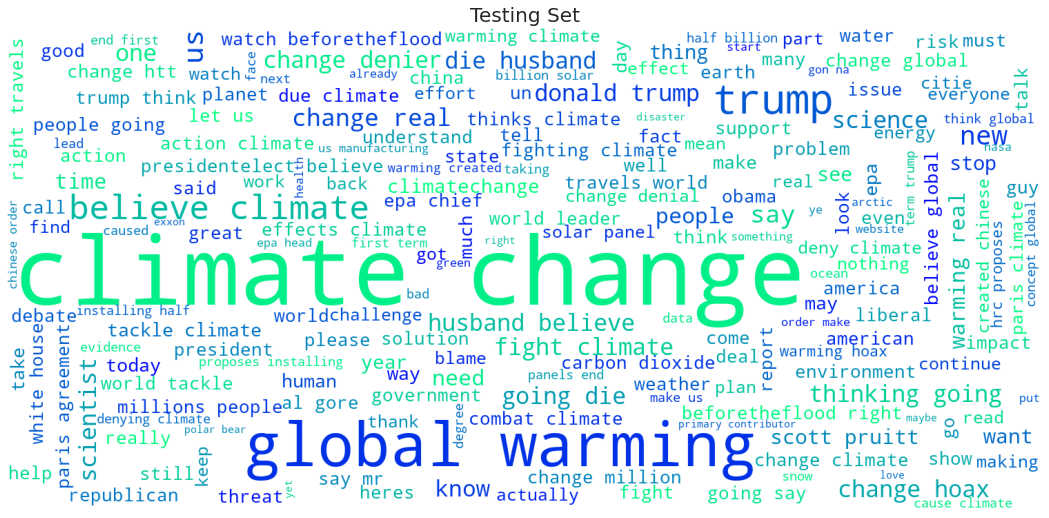

In [39]:
# Wordcloud for Testing Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Testing Set",fontsize=20)
plt.imshow(test_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

### Word Counts

In [40]:
def word_counts(text, n):
    """
    Word Counts With Bigrams.
    Ref: https://github.com/robsalgado/personal_data_science_projects/blob/master/mulitclass_text_class/nlp_utils_news.ipynb
    """
    phrases = Phrases(text, min_count=2, threshold=1)
    phrases = list(phrases[text])
    flatten_phrases = [item for phrase in phrases for item in phrase]
    phrases_counts = Counter(flatten_phrases)
    top = phrases_counts.most_common(n)
    word = [i[0] for i in top]
    num = [j[1] for j in top]
    return pd.DataFrame([word, num]).T

In [41]:
# Get Word Counts for Top 15 Words Per Sentiment Class
count_news = word_counts(train_news['message'], n=15)
count_pro = word_counts(train_pro['message'], n=15)
count_neutral = word_counts(train_neutral['message'], n=15)
count_anti = word_counts(train_anti['message'], n=15)

df_word_counts = pd.concat([count_news,count_pro,count_neutral,count_anti], axis=1)
df_word_counts.columns = ['News (2)','count','Pro (1)','count','Neutral (0)','count','Anti (-1)','count']
df_word_counts

,News (2),count,Pro (1),count,Neutral (0),count,Anti (-1),count
0,climate_change,2094,climate_change,4117,climate_change,1037,climate_change,605
1,change,789,change,2234,global_warming,683,global_warming,440
2,global_warming,306,global_warming,900,change,286,warming,122
3,trump,270,believe_climate,490,warming,259,change,105
4,us,161,trump,344,trump,97,science,55
5,says,139,real,340,like,78,trump,54
6,warming,97,thinking_going,308,I,75,climate,51
7,donald_trump,95,die_husband,308,us,73,real,50
8,scientists,93,warming,306,people,53,scam,43
9,fight_climate,89,us,243,real,46,hoax,41


In [42]:
# train = train_data.copy()
# word = []
# for i in train['message']:
#     if "climate change" in i:
#         word.append("climate change")
#     elif "global warming" in i:
#         word.append("global warming")
#     else:
#         word.append("z")
# train['word'] = word
# train = train[~train.word.str.contains("z")]
# sns.factorplot(x='word', hue='sentiment', 
#                     data=train, kind="count", 
#                     palette='winter')
# plt.title('Frequency Per Sentiment Class',fontsize=14)
# plt.xlabel('')
# plt.ylabel('Frequency')
# plt.show()

In [43]:
# train = train_data.copy()
# word = []
# for i in train['message']:
#     if "trump" in i:
#         word.append("trump")
#     elif "science" in i:
#         word.append("science")
#     else:
#         word.append(" ")
# train['word'] = word
# train = train[~train.word.str.contains(" ")]
# sns.factorplot(x='word', hue='sentiment', 
#                     data=train, kind="count", 
#                     palette='winter')
# plt.title('Frequency Per Sentiment Class',fontsize=14)
# plt.xlabel('')
# plt.ylabel('Frequency')
# plt.show()

<a id="preprocessing"></a>
## 5. Data Preprocessing

### Lemmatisation

In [45]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatise_words(text):
    words = []
    for word in text:
        words.append(lemmatizer.lemmatize(word))
    return words

train_data['message'] = train_data['message'].apply(lemmatise_words)
test_data['message'] = test_data['message'].apply(lemmatise_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Feature Extraction

In [46]:
def do_nothing(tokens):
    return tokens
vect = CountVectorizer(lowercase=False,tokenizer=do_nothing,max_features=20,analyzer='word') # Max features ??
X_count = vect.fit_transform(train_data['message'])

In [47]:
X_count.shape

(15819, 20)

### Split Training and Validation Sets

In [48]:
X = X_count.toarray()
y = train_data['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 42)

### Resampling

In [ ]:
# Class size = roughly half the size of the largest size (i.e. 4000)

**bold text**<a id="modelling"></a>
## 6. Modelling

### Naive Bayes

### Logistic Regression

### K Nearest Neighbours

In [ ]:
#

### Linear SVM

#### SVM Clean Data

In [50]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=10, random_state=42)

svc.fit(X_train, y_train)

predicted = svc.predict(X_val)

np.mean(predicted == y_val)

0.5701643489254109

#### SVM Rougly Clean

In [51]:
# Large pretrained model
# Use medium if you have it

# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en --force
# import spacy
# nlp=spacy.load('en')

     |████████████████████████████████| 827.9MB 1.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=30c93541ddaa3ba1d261d654f2763747849b7870c8e0a2548fd3a8ba501daf87
  Stored in directory: /tmp/pip-ephem-wheel-cache-qmbworo8/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import nltk
import pandas as pd
import spacy

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

#import
train = pd.read_csv('Data/train.csv')

# Tokenize
train.message = train.message.apply(nlp.tokenizer)
train.message = train.message.apply(lambda x: [token.lemma_ for token in x if not token.is_stop])
train.message = train.message.apply(lambda x: " ".join(x))
X, val_x, y, val_y = train_test_split(train[['message']], train['sentiment'], test_size = 0.3, random_state=42)

# Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 8), stop_words=spacy_stopwords)
tfidf.fit(X['message'])
X_tfidf = tfidf.transform(X['message'])

val_xtfidf = tfidf.transform(val_x['message'])

# Scale
sc = StandardScaler(with_mean=False)
sc.fit(X_tfidf)

X_tfidf = sc.transform(X_tfidf)
val_xtfidf = sc.transform(val_xtfidf)

# Fit model
clf = LinearSVC(C=10, random_state=42)
clf.fit(X_tfidf, y)

# Evaluate model
predicted = clf.predict(val_xtfidf)
np.mean(predicted == val_y)

0.6936367467340918

### Word2Vec with Logistic Regression

### Doc2Vec with t-SNE

<a id="evaluation"></a>
## 7. Performance Evaluation

### Performance Metrics of Best Models

### Hyperparemeter Tuning of Best Models

<a id="analysis"></a>
## 8. Model Analysis

### Performance Metrics

### ROC Curves and AUC

<a id="conclusion"></a>
## 9. Conclusion

<a id="save"></a>
## 10. Save Model and Output

In [ ]:
# Create Kaggle submission file
# final_model = model(parameters)
# final_model.fit(X,y)
# y_test = final_model.predict(X_test)
# results = pd.DataFrame({"tweetid":test_data['tweetid'],"sentiment": y_test})
# results.to_csv("Team_RM5_submission.csv", index=False)

In [ ]:
# Save model
# model_save_path = "Team_RM5_model.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(final_model,file)

[Back to top ↑](#top)

<sub>*Team name credit: Ridha (& Freud's mom)</sub>